In [1]:
import tensorflow as tf
import keras
from keras import layers
import pandas as pd
import numpy as np
from custom_layers_def import TubeletEmbedding, PositionalEncoder
import os
import matplotlib.pyplot as plt
from utils.normalizations_landmarks import normalize_from_0_landmark, normalize_from_first_frame
from IPN_Hand_utils.dataset_windowing import windowing, WindowSettings

2023-12-14 01:28:56.207034: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-14 01:28:56.207078: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-14 01:28:56.208091: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-14 01:28:57.161665: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Model Params

In [5]:
INTERPOLATION = 3
INPUT_SHAPE = (561,42,1)
NUM_LAYERS = 1
NUM_HEADS = 8
PROJECTION_DIM = 64
NORMALIZATION = "FF"
GESTURE_LABEL = 4

DATA = "pose_features_w_interp"
DATA_PATH = f'../features/IPN_Hand/{DATA}'
if INTERPOLATION != 0:
    DATA_PATH = f'{DATA_PATH}_interp_{INTERPOLATION}'
GAD_ACTIVE = True
GAD_MODE = "PEAK"

MODEL_PATH = "/home/josemanuelbravo/Escritorio/GestureRecognitionSystem/models/IPN_Hand/patch-(30, 42)/projection_dim-64/num_heads-8/num_layers-1/dropout_rate-0.1/norm-FF/interp-3/model.keras"

# Database utility functions

In [6]:
def generate_video_landmarks(annotations_list):
    '''
        Gets the annotation list of a video and returns a tuple with the array of landmarks and the label of the video.

        Params:
         -annotations_list: List with the information of the video: [video_name, label_name, label, first_frame, last_frame, number_frames]

        Returns:
         -(landmarks, label)
    '''
    video_name = annotations_list[0]
    label = annotations_list[2] - 1 # To have them between 0 and 13 instead of 1 and 14
    first_frame = annotations_list[3]
    last_frame = annotations_list[4]

    #Recover the landmarks from the csv files
    csv_path = os.path.join(f"../features/IPN_Hand/pose_features_windowed/",f"{video_name}_poses_landamarks.csv")

    full_video_landmarks = pd.read_csv(csv_path).to_numpy()

    #Get only the gesture frames
    landmarks = full_video_landmarks[first_frame:last_frame,0:INPUT_SHAPE[1]]
    #Normalize the frames
    if NORMALIZATION == "L0":
        landmarks = normalize_from_0_landmark(landmarks)
    elif NORMALIZATION == "FF":
        landmarks = normalize_from_first_frame(landmarks)

    #Parse the landmarks  
    landmarks = landmarks.astype(np.float32)

    return (landmarks, label)

# Load and predict

In [7]:
#Make the windowing
window_settings = WindowSettings(
    data_path=DATA_PATH,
    interpolation=INTERPOLATION,
    window_size=INPUT_SHAPE[0],
    gad_active=GAD_ACTIVE,
    gad_mode=GAD_MODE
)
print(f"\033[94m Windowing:\033[00m Making windows with a size of {INPUT_SHAPE[0]} frames")
windowing(window_settings)

#Load the data
annotation_list = pd.read_csv("../features/IPN_Hand/pose_features_windowed/Annot_TestList.txt")
annotation_list = annotation_list[annotation_list["label"] == GESTURE_LABEL]
annotation_list = annotation_list.to_numpy()
landmarks,_ = generate_video_landmarks(annotation_list[0])

#Load the model
model = keras.models.load_model(MODEL_PATH, custom_objects={'TubeletEmbedding': TubeletEmbedding, 'PositionalEncoder': PositionalEncoder})
model.summary()

#Load the submodel for the attention map
attention_maps = []

for layer in range(NUM_LAYERS):
    attention_layer = model.get_layer(index=5+(7*layer))
    print(attention_layer)
    submodel = keras.models.Model(inputs=model.input, outputs=model.get_layer(index=4+(7*layer)).output)
    submodel_outputs = submodel.predict(landmarks.reshape(1,INPUT_SHAPE[0],INPUT_SHAPE[1],1))
    _, attention_scores = attention_layer(submodel_outputs, submodel_outputs, return_attention_scores=True)

    attentions = attention_scores[0,:,0,:]
    print(attentions.shape)
    attention_maps.append(attentions)



 Windowing: Making windows with a size of 561 frames
 Windowing: Making windows with a size of 561 frames
 Windowing: Previous windowing settings found but do not match or force_windowing is set to True. Windowing will be performed.


 Windowing:   0%|          | 0/200 [00:00<?, ?it/s]

 Windowing: 100%|██████████| 200/200 [14:29<00:00,  4.35s/it]


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 561, 42, 1)]         0         []                            
                                                                                                  
 tubelet_embedding (Tubelet  (None, 18, 64)               80704     ['input_1[0][0]']             
 Embedding)                                                                                       
                                                                                                  
 positional_encoder (Positi  (None, 18, 64)               1152      ['tubelet_embedding[0][0]']   
 onalEncoder)                                                                                     
                                                                                              

2023-12-14 02:14:21.547987: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-12-14 02:14:21.621744: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-12-14 02:14:21.784522: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 1s 639ms/step
(8, 18)


# Plot the attention maps

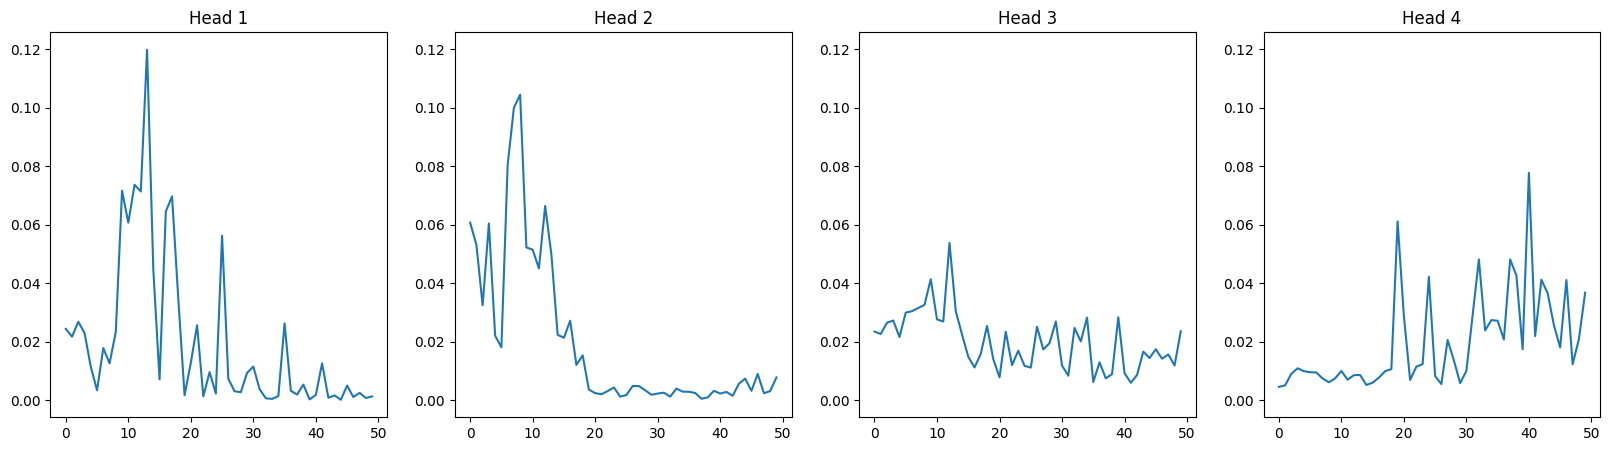

: 

In [ ]:
fig, axs = plt.subplots(NUM_LAYERS,NUM_HEADS, figsize=(20,5))
#axs = axs.flatten()
if NUM_LAYERS == 1:
    for head in range(NUM_HEADS):
        ax = axs[head]
        ax.set_title(f"Head {head+1}")
        ax.sharex(axs[0])
        ax.sharey(axs[0])
        ax.plot(attention_maps[0][head, :])
else:
    for layer in range(NUM_LAYERS):
        for head in range(NUM_HEADS):
            ax = axs[layer,head]
            ax.set_title(f"Layer {layer+1}, Head {head+1}")
            ax.sharex(axs[0,0])
            ax.sharey(axs[0,0])
            ax.plot(attention_maps[layer][head, :])
    